Considering the harmonic oscillator system: 
$$ \dot{y} = \begin{bmatrix}
           \dot{p} \\
           \dot{q} \\
         \end{bmatrix} = 
    \begin{bmatrix}
           q \\
           -p \\
         \end{bmatrix} = f(p,h)  $$

Using 1-dimentional discontinous Galerkin FEM. The discretization (per element) is given by
$$ 
\int_{I_n} (\dot{y_h} - f(p_h,q_h))\phi \ dt \ + \llbracket y_n\rrbracket \phi_n(t_j) = 0
$$ 
Ordering is chosen to let $y_h$ contain alternate elements of $p_h$ and $q_h$ such that the resulting linear system is block tridiagonal, i.e: 
$$
\begin{align}
y &= \begin{bmatrix} ... & y_n^- & y_n^+ & y_{n+1}^- & ...  \end{bmatrix} \\
  &= \begin{bmatrix} ... & p_n^- & q_n^- & p_n^+ & q_n^+ & p_{n+1}^- & q_{n+1}^- & ...  \end{bmatrix}
\end{align}
$$

In [146]:
#!pip install numpy matplotlib scipy tqdm
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, vstack, hstack, save_npz, load_npz
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

In [71]:
def computer(p,k):
    return p*2**k-1

# Two processes
for k in range(1,8):
    print(computer(8,k))    

15
31
63
127
255
511
1023


In [58]:
arr1 = lil_matrix(np.zeros(4)).toarray().reshape(-1,1)
arr2 = lil_matrix([1,2,3,4]).toarray().reshape(-1,1)
print(arr1.shape)
print(arr2.shape)

np.concatenate((arr1, arr2))

(4, 1)
(4, 1)


array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [2.],
       [3.],
       [4.]])

100%|██████████| 100/100 [00:00<00:00, 6451.39it/s]


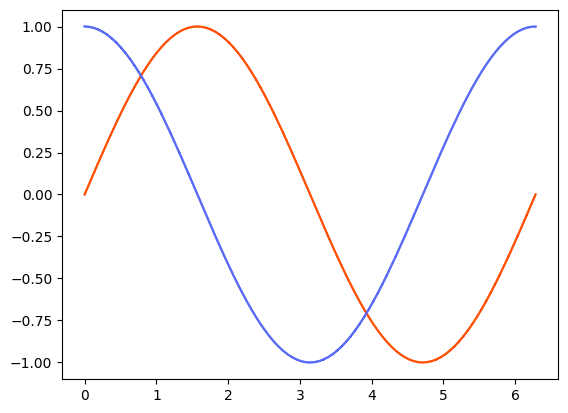

In [147]:
N = 100
dof = 4
T = 2*np.pi
h = T/N 
t = np.arange(0, T+h, h)
p_0 = 0
q_0 = 1

# p' = -q, q' = p
# main_block_matrix = np.array([
#     [0.5, h/3, 1/2, h/6], 
#     [-h/3, 0.5, -h/6, 1/2], 
#     [-0.5, h/6, 0.5, h/3],
#     [-h/6, -0.5, -h/3, 0.5]
#     ])

# p' = q, q' = -p
main_block_matrix = np.array([
    [0.5, -h/3, 1/2, -h/6], 
    [h/3, 0.5, h/6, 1/2], 
    [-0.5, -h/6, 0.5, -h/3],
    [h/6, -0.5, h/3, 0.5]
    ])

lower_block_matrix = np.zeros((dof, dof))
lower_block_matrix[0, -2] = -1
lower_block_matrix[1, -1] = -1
upper_block_matrix = np.zeros((dof, dof))

# def construct_block_tridiagonal_matrix(A, B, C, N):
#     """
#     Construct a block-tridiagonal matrix in CSR format.
    
#     Parameters:
#     A: 4x4 array, lower block matrix
#     B: 4x4 array, main block matrix
#     C: 4x4 array, upper block matrix
#     N: integer, number of blocks along one dimension
    
#     Returns:
#     CSR sparse matrix of size (4*N, 4*N)
#     """
#     dof = A.shape[0]  # This should be 4 since A, B, and C are 4x4

#     # Initialize empty lists for blocks to construct block matrix
#     blocks = []
    
#     # Construct the first block row
#     block_row = [csr_matrix(B)]  # The first block is B
#     if N > 1:
#         block_row.append(csr_matrix(C))  # Followed by C
#     block_row.extend([csr_matrix((dof, dof))] * (N-2))  # Remaining blocks in this row are zero
#     blocks.append(hstack(block_row))  # Stack horizontally to form the first row

#     # Construct the inner block rows
#     for i in tqdm(range(1, N-1)):
#         block_row = [csr_matrix((dof, dof))] * (i-1)  # Start with (i-1) zero blocks
#         block_row.append(csr_matrix(A))  # Add A to the sub-diagonal position
#         block_row.append(csr_matrix(B))  # Add B to the main diagonal
#         block_row.append(csr_matrix(C))  # Add C to the super-diagonal
#         block_row.extend([csr_matrix((dof, dof))] * (N-i-2))  # Fill the rest with zero blocks
#         blocks.append(hstack(block_row))  # Stack to form the row

#     # Construct the last block row
#     if N > 1:
#         block_row = [csr_matrix((dof, dof))] * (N-2)  # First (N-2) blocks are zero
#         block_row.append(csr_matrix(A))  # Then A
#         block_row.append(csr_matrix(B))  # Finally B
#         blocks.append(hstack(block_row))  # Stack to form the last row
    
#     # Stack all rows vertically
#     block_tridiagonal_matrix = vstack(blocks)

#     return block_tridiagonal_matrix.tocsr()

# def construct_rhs_vector(p_0, q_0, N, dof=4):
#     """
#     Construct a right-hand side (RHS) vector in CSR format.
    
#     Parameters:
#     p_0: scalar, first entry
#     q_0: scalar, second entry
#     N: integer, number of blocks
#     dof: degrees of freedom per block (should be 4)
    
#     Returns:
#     Sparse CSR vector of size (4*N)
#     """
#     rhs = lil_matrix((dof * N,1))
#     rhs[0] = p_0  # First entry
#     rhs[1] = q_0  # Second entry
    
#     return rhs

def construct_block_tridiagonal_matrix(A, B, C, N):
    """
    Construct a block-tridiagonal matrix in CSR format.
    
    Parameters:
    A: 4x4 array, lower block matrix
    B: 4x4 array, main block matrix
    C: 4x4 array, upper block matrix
    N: integer, number of blocks along one dimension
    
    Returns:
    CSR sparse matrix of size (4*N, 4*N)
    """
    dof = A.shape[0]  # This should be 4 since A, B, and C are 4x4

    # Preallocate a sparse matrix in LIL format for efficient row construction
    block_tridiagonal_matrix = lil_matrix((4*N, 4*N))

    # Fill in the main diagonal and off-diagonal blocks
    for i in tqdm(range(N)):
        # Main diagonal
        block_tridiagonal_matrix[4*i:4*(i+1), 4*i:4*(i+1)] = B

        if i > 0:  # Fill the lower diagonal
            block_tridiagonal_matrix[4*i:4*(i+1), 4*(i-1):4*i] = A
            
        if i < N - 1:  # Fill the upper diagonal
            block_tridiagonal_matrix[4*i:4*(i+1), 4*(i+1):4*(i+2)] = C

    return block_tridiagonal_matrix.tocsr()

def construct_rhs_vector(p_0, q_0, N, dof=4):
    """
    Construct a right-hand side (RHS) vector in CSR format.
    
    Parameters:
    p_0: scalar, first entry
    q_0: scalar, second entry
    N: integer, number of blocks
    dof: degrees of freedom per block (should be 4)
    
    Returns:
    Sparse CSR vector of size (4*N)
    """
    # Initialize the right-hand side vector in LIL format
    rhs = lil_matrix((dof * N, 1))
    rhs[0, 0] = p_0  # First entry
    rhs[1, 0] = q_0  # Second entry
    
    return rhs.tocsr()

A = construct_block_tridiagonal_matrix(lower_block_matrix, main_block_matrix, upper_block_matrix, N)
f = construct_rhs_vector(p_0, q_0, N, dof)

y = spsolve(A, f)
p = y[::2]
q = y[1::2]

def plot_solution(t, u, true_solution, colors=['red', 'green']):
    tp = np.array([t[i:i+2] for i in range(0, N)]).flatten() # time points in each element
    U = np.array([u[i:i+2] for i in range(0, len(u), 2)]).flatten() # approximate solution in each element
    V = true_solution(tp) # true solution in each element
    plt.plot(tp, U, color=colors[0])
    plt.plot(tp, V, color=colors[1], alpha=0.5)

def solution_p(t):
    return np.sin(t)

def solution_q(t):
    return np.cos(t)

plot_solution(t, p, solution_p, colors=['red', 'orange'])
plot_solution(t, q, solution_q, colors=['blue', 'lightblue'])

In [13]:
# Define the 3x3 blocks
block_1 = np.random.randint(0, 10, (3, 3))
block_2 = np.random.randint(0, 10, (3, 3))
block_3 = np.random.randint(0, 10, (3, 3))
off_diag_1 = np.random.randint(0, 10, (3, 3))
off_diag_2 = np.random.randint(0, 10, (3, 3))

# Construct the 9x9 block tridiagonal matrix
A1 = np.block([
    [block_1, off_diag_1, np.zeros((3, 3))],
    [off_diag_1.T, block_2, off_diag_2],
    [np.zeros((3, 3)), off_diag_2.T, block_3]
])

f1 = np.arange(1, 10)

In [4]:
def cyclic_reduction_parallel(A, f, block_size, max_depth=3, depth=0):
    m, n = A.shape
    # if not isinstance(A, csr_matrix):
    #     A = csr_matrix(A)

    # Number of diagonal blocks for the given block size
    number_of_diagonal_blocks = m // block_size
    n_odd = number_of_diagonal_blocks // 2  # number of diagonal blocks with odd indices
    n_even = number_of_diagonal_blocks - n_odd  # number of diagonal blocks with even indices
    
    # if depth >= max_depth:
    #     return spsolve(A, f)
    
    B = np.zeros((m, n))
    g = np.zeros(m)

    # Even indices diagonal (process the even diagonal blocks first)
    for i in range(n_even):
        j = 2 * i
        B[block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1), block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, j * block_size:(j + 1) * block_size]
        g[block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1)] = f[j * block_size:(j + 1) * block_size]

    # Odd indices diagonal (process the odd diagonal blocks)
    for i in range(n_odd):
        j = 2 * i + 1
        B[block_size * i:block_size * (i + 1), block_size * i:block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, j * block_size:(j + 1) * block_size]
        g[block_size * i:block_size * (i + 1)] = f[j * block_size:(j + 1) * block_size]

    # Off-diagonal blocks, even indices (F_i)
    for i in range(n_odd):
        j = 2 * i
        B[block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1), block_size * i:block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, (j + 1) * block_size:(j + 2) * block_size]
    
    # Off-diagonal blocks, odd indices (F_i)
    for i in range(n_even - 1):
        j = 2 * i + 1
        B[block_size * i:block_size * (i + 1), block_size * n_odd + block_size * (i + 1):block_size * n_odd + block_size * (i + 2)] = A[j * block_size:(j + 1) * block_size, (j + 1) * block_size:(j + 2) * block_size]

    # Off-diagonal blocks, even indices (E_i)
    for i in range(n_even - 1):
        j = 2 * i
        B[block_size * n_odd + block_size * (i + 1):block_size * n_odd + block_size * (i + 2), block_size * i:block_size * (i + 1)] = A[(j + 2) * block_size:(j + 3) * block_size, (j + 1) * block_size:(j + 2) * block_size]

    # Off-diagonal blocks, odd indices (E_i)
    for i in range(n_odd):
        j = 2 * i + 1
        B[block_size * i:block_size * (i + 1), block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, (j - 1) * block_size:j * block_size]

    # Extract D1, D2, F, G based on block partitions
    D1 = B[0:n_odd * block_size, 0:n_odd * block_size]
    F = B[0:n_odd * block_size, n_odd * block_size:]
    G = B[n_odd * block_size:, 0:n_odd * block_size]
    D2 = B[n_odd * block_size:, n_odd * block_size:]
    print(A)
    print("\n")
    print(B, "\n\n", g)

cyclic_reduction_parallel(A1,f1,3)

[[8. 7. 6. 2. 8. 8. 0. 0. 0.]
 [6. 0. 3. 1. 0. 7. 0. 0. 0.]
 [3. 8. 1. 6. 5. 2. 0. 0. 0.]
 [2. 1. 6. 2. 9. 1. 5. 1. 7.]
 [8. 0. 5. 4. 9. 4. 8. 1. 5.]
 [8. 7. 2. 3. 9. 9. 0. 1. 3.]
 [0. 0. 0. 5. 8. 0. 7. 0. 7.]
 [0. 0. 0. 1. 1. 1. 4. 6. 5.]
 [0. 0. 0. 7. 5. 3. 5. 2. 3.]]


[[2. 9. 1. 2. 1. 6. 5. 1. 7.]
 [4. 9. 4. 8. 0. 5. 8. 1. 5.]
 [3. 9. 9. 8. 7. 2. 0. 1. 3.]
 [2. 8. 8. 8. 7. 6. 0. 0. 0.]
 [1. 0. 7. 6. 0. 3. 0. 0. 0.]
 [6. 5. 2. 3. 8. 1. 0. 0. 0.]
 [5. 8. 0. 0. 0. 0. 7. 0. 7.]
 [1. 1. 1. 0. 0. 0. 4. 6. 5.]
 [7. 5. 3. 0. 0. 0. 5. 2. 3.]] 

 [4. 5. 6. 1. 2. 3. 7. 8. 9.]


In [145]:
def possible_mat_size(p,k):
    return p*2**(k+1)-1

for i in range(1,16):
    print(possible_mat_size(8,i))
#possible_mat_size(2,2)

31
63
127
255
511
1023
2047
4095
8191
16383
32767
65535
131071
262143
524287


In [152]:
possibilities = [31,63,127,255,511,1023,2047,4095,8191,16383,32767,65535,131071,262143,524287]

In [154]:

N = 15
A = construct_block_tridiagonal_matrix(lower_block_matrix, main_block_matrix, upper_block_matrix, N)
f = construct_rhs_vector(p_0, q_0, N, dof)
x = csr_matrix(spsolve(A, f))
A = save_npz(f"sparse_harmonic/A_{N}.npz", A)
f = save_npz(f"sparse_harmonic/f_{N}.npz", f)
x = save_npz(f"sparse_harmonic/x_{N}.npz", x)

100%|██████████| 15/15 [00:00<00:00, 2714.29it/s]


In [88]:
from scipy.sparse import csr_matrix, lil_matrix, vstack, hstack, save_npz, load_npz, block_diag

In [176]:
a_arr = []
c_arr = []
b_arr = []
for i in range(1,16):
    a = np.eye(4)
    c = np.zeros((4,4)) 
    b = np.zeros((4,4))
    a_arr.append(a)
    c_arr.append(c)
    b_arr.append(b)


A = block_diag(a_arr, format='csr')

for i in range(1,15):
    A[i*4:(i+1)*4, (i-1)*4:i*4] = b_arr[i]
    A[(i-1)*4:i*4, i*4:(i+1)*4] = c_arr[i]

#A = A.toarray()
print(A.shape)
f = np.arange(1, (15)*4+1).reshape(1,-1)
f = lil_matrix(f).tocsr()
print(f.shape)
#x = np.linalg.solve(A, f)

def print_blocks_of_block_tridiagonal_matrix(A, block_size):
    # Prints the blocks of a block-tridiagonal matrix, including the main diagonal and off-diagonal blocks

    m = A.shape[0]//block_size # matrix is symmetric
    
    # print diagonal blocks
    for i in range(m):
        print(f"Main A[{i},{i}]")
        print(A[i*block_size:(i+1)*block_size, i*block_size:(i+1)*block_size])
        print("\n")
    # print upper diagonal blocks
    for i in range(1, m):
        print(f"Upper A[{i-1},{i}]")
        print(A[(i-1)*block_size:i*block_size, i*block_size:(i+1)*block_size])
        print("\n")
    # print lower diagonal blocks
    for i in range(1, m):
        print(f"Lower A[{i},{i-1}]")
        print(A[i*block_size:(i+1)*block_size, (i-1)*block_size:i*block_size])
        print("\n")
    
            
    

#A = save_npz(f"sparse_harmonic/A_test.npz", A)
#f = save_npz(f"sparse_harmonic/f_test.npz", f)
x = spsolve(A, f.T)
x = lil_matrix(x).tocsr()
x = save_npz(f"sparse_harmonic/x_test.npz", x)


(60, 60)
(1, 60)


c:\Users\tinus\OneDrive\Desktop\Mastah\La Code\.venv\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [170]:
print(A.shape)
print(f.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [169]:
A = save_npz(f"sparse_harmonic/A_test.npz", A)
f = save_npz(f"sparse_harmonic/f_test.npz", f)
x = spsolve(A, f.T)
x = save_npz(f"sparse_harmonic/x_test.npz", x)

AttributeError: 'NoneType' object has no attribute 'T'

In [5]:
import os

# Specify the path to your file
file_path = "sparse_harmonic/A_100000.npz"  # Change this to your file path

# Get the file size in bytes
file_size = os.path.getsize(file_path)
 
# Convert to MB (optional)
file_size_mb = file_size / (1024 * 1024)

print(f"File size: {file_size} bytes ({file_size_mb:.2f} MB)")

File size: 1661086 bytes (1.58 MB)


In [12]:
np.set_printoptions(precision=2, suppress=True)

def generate_permutation_matrix(n,block_size):
    if n % 2 == 0:
        raise ValueError("n must be odd for this specific reordering.")
    Q = np.eye(n*block_size)
    odd_indices = list(range(0, n*block_size, block_size)) 
    even_indices = list(range(1, n*block_size, block_size)) 
    new_order = odd_indices + even_indices
    for i, j in enumerate(new_order):
        Q[i, j] = 1
    return Q

def create_full_permutation_matrix(m, block_size):
    # Total number of blocks
    num_blocks = m // block_size  # For m = 12, block_size = 4, num_blocks = 3

    # Initialize an identity matrix of size m x m
    Q = np.zeros((m, m))

    # Define the permutation order: [Block 1, Block 0, Block 2]
    perm_order = []
    for i in range(num_blocks):
        if i % 2 == 1:  # Append odd blocks first (1)
            perm_order.append(i)
    for i in range(num_blocks):
        if i % 2 == 0:  # Append even blocks next (0, 2)
            perm_order.append(i)

    # Fill the permutation matrix
    for new_index, old_index in enumerate(perm_order):
        start_new = new_index * block_size
        start_old = old_index * block_size
        Q[start_new:start_new + block_size, start_old:start_old + block_size] = np.eye(block_size)

    return csr_matrix(Q)

A, f, x = load_npz("sparse_harmonic/A_3.npz"), load_npz("sparse_harmonic/f_3.npz"), load_npz("sparse_harmonic/x_3.npz").T
m = A.shape[0]
A = A.toarray()
Q = create_full_permutation_matrix(m,4)
print(A)
print(Q@A@Q.T)
print(f.T.toarray())
#print((Q@f).T)

[[ 0.5  -0.02  0.5  -0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.5   0.01  0.5   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.5  -0.01  0.5  -0.02  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01 -0.5   0.02  0.5   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -1.    0.    0.5  -0.02  0.5  -0.01  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -1.    0.02  0.5   0.01  0.5   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.5  -0.01  0.5  -0.02  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.01 -0.5   0.02  0.5   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -1.    0.    0.5  -0.02  0.5  -0.01]
 [ 0.    0.    0.    0.    0.    0.    0.   -1.    0.02  0.5   0.01  0.5 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.5  -0.01  0.5  -0.02]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.01 -0.5   0.02  0.5 ]]
[[ 0.5  -0.02  0.5  -0.01  0.    0.   -1.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.5   0.01  0.5

In [24]:
print(A1,"\n\n",f1,"\n\n")
Q1 = create_full_permutation_matrix(A1.shape[0],3)
print(Q1@A1@Q1.T,"\n\n",Q1@f1)

[[1. 0. 5. 4. 6. 5. 0. 0. 0.]
 [5. 9. 9. 8. 0. 1. 0. 0. 0.]
 [9. 0. 9. 1. 8. 8. 0. 0. 0.]
 [4. 8. 1. 2. 9. 3. 7. 8. 9.]
 [6. 0. 8. 7. 7. 9. 5. 0. 4.]
 [5. 1. 8. 6. 0. 8. 0. 1. 2.]
 [0. 0. 0. 7. 5. 0. 1. 4. 2.]
 [0. 0. 0. 8. 0. 1. 0. 9. 3.]
 [0. 0. 0. 9. 4. 2. 0. 8. 0.]] 

 [1 2 3 4 5 6 7 8 9] 


[[2. 9. 3. 4. 8. 1. 7. 8. 9.]
 [7. 7. 9. 6. 0. 8. 5. 0. 4.]
 [6. 0. 8. 5. 1. 8. 0. 1. 2.]
 [4. 6. 5. 1. 0. 5. 0. 0. 0.]
 [8. 0. 1. 5. 9. 9. 0. 0. 0.]
 [1. 8. 8. 9. 0. 9. 0. 0. 0.]
 [7. 5. 0. 0. 0. 0. 1. 4. 2.]
 [8. 0. 1. 0. 0. 0. 0. 9. 3.]
 [9. 4. 2. 0. 0. 0. 0. 8. 0.]] 

 [4. 5. 6. 1. 2. 3. 7. 8. 9.]
